<a href="https://colab.research.google.com/github/CodePool-soham/Data-Science/blob/main/PROJECT_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [ ]:
# Load CSV file
df = pd.read_csv('/content/data.csv')

In [ ]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [ ]:
df.shape

(13320, 9)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [ ]:
df.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [ ]:
# Create a new column 'bhk' by extracting the number from 'size'
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]) if isinstance(x, str) else None)

# Quick check
print(df[['size', 'bhk']].head(10))


        size  bhk
0      2 BHK  2.0
1  4 Bedroom  4.0
2      3 BHK  3.0
3      3 BHK  3.0
4      2 BHK  2.0
5      2 BHK  2.0
6      4 BHK  4.0
7      4 BHK  4.0
8      3 BHK  3.0
9  6 Bedroom  6.0


In [ ]:
def convert_sqft_to_num(x):
    try:
        if '-' in x:
            tokens = x.split('-')
            return (float(tokens[0]) + float(tokens[1])) / 2
        return float(x)
    except:
        return None

df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)

# Check some rows
print(df[['total_sqft']].head(10))



   total_sqft
0      1056.0
1      2600.0
2      1440.0
3      1521.0
4      1200.0
5      1170.0
6      2732.0
7      3300.0
8      1310.0
9      1020.0


In [ ]:
# Drop rows with missing total_sqft, bath, price, or bhk
df = df.dropna(subset=['total_sqft', 'bath', 'price', 'bhk'])

# Drop rows with bhk or total_sqft still null or invalid (very rare but safe)
df = df[(df['bhk'] > 0) & (df['total_sqft'] > 0)]

# Check shape after cleaning
print("Dataset shape after cleaning:", df.shape)


Dataset shape after cleaning: (13201, 10)


In [ ]:
# Fill missing location with 'unknown'
df['location'] = df['location'].fillna('unknown')

# Remove leading/trailing spaces
df['location'] = df['location'].apply(lambda x: x.strip())

# Group locations with less than 10 occurrences
location_stats = df['location'].value_counts()
location_stats_less_than_10 = location_stats[location_stats < 10]

# Replace rare locations with 'other'
df['location'] = df['location'].apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

# Show summary
print("Number of unique locations:", df['location'].nunique())
print(df['location'].value_counts().head(10))


Number of unique locations: 255
location
other              2733
Whitefield          533
Sarjapur  Road      392
Electronic City     304
Kanakpura Road      264
Thanisandra         235
Yelahanka           210
Uttarahalli         186
Hebbal              176
Marathahalli        175
Name: count, dtype: int64


In [ ]:
df = df[df['total_sqft'] / df['bhk'] >= 300]

In [ ]:
df['price_per_sqft'] = (df['price'] * 100000) / df['total_sqft']
print(df[['location', 'price_per_sqft']].describe())


       price_per_sqft
count    12457.000000
mean      6308.427888
std       4167.968413
min        267.829813
25%       4210.526316
50%       5294.117647
75%       6916.666667
max     176470.588235


In [ ]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft >= (m - st)) & (subdf.price_per_sqft <= (m + st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

df = remove_pps_outliers(df)

# Check new shape
print("Shape after removing pps outliers:", df.shape)


Shape after removing pps outliers: (10223, 11)


## EDA

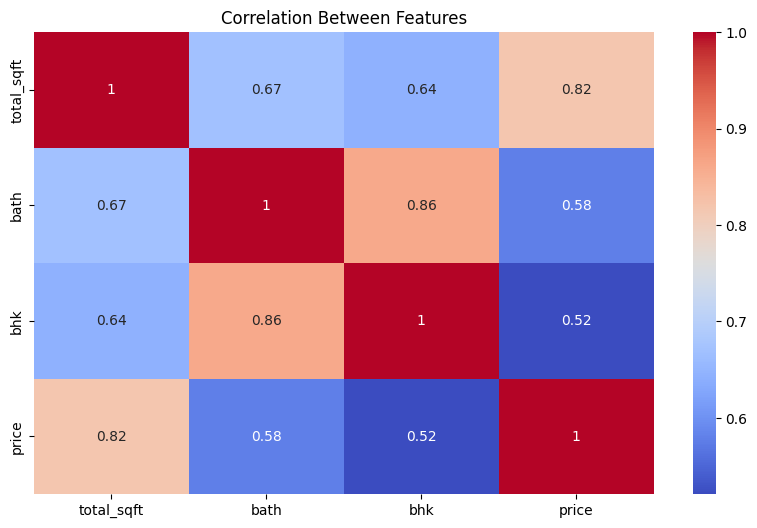

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df[['total_sqft', 'bath', 'bhk', 'price']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Features")
plt.show()


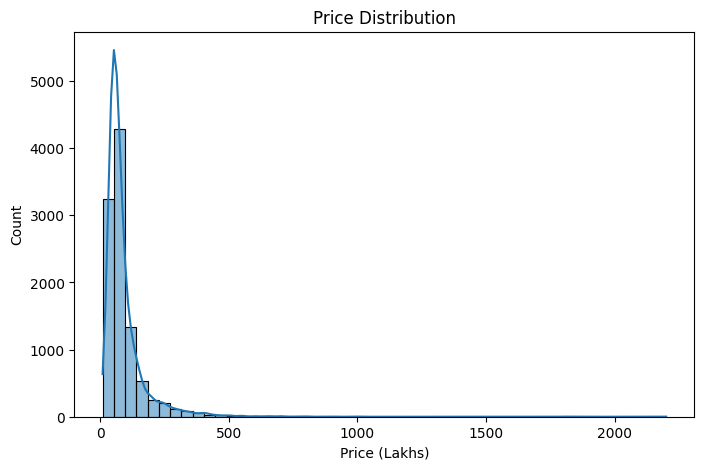

In [ ]:

plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price (Lakhs)")
plt.show()

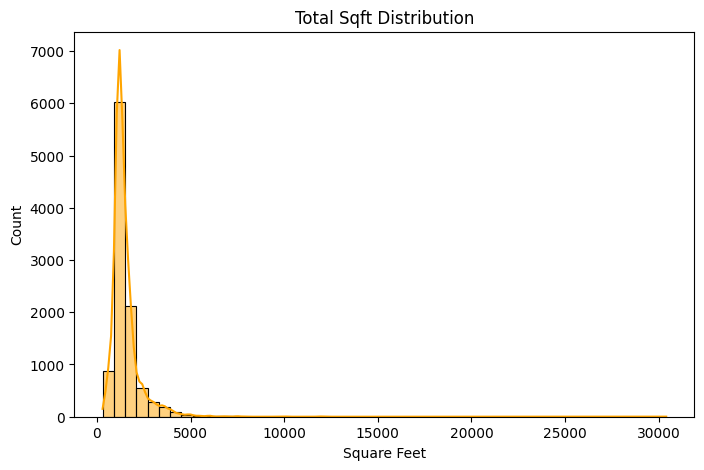

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['total_sqft'], bins=50, kde=True, color='orange')
plt.title("Total Sqft Distribution")
plt.xlabel("Square Feet")
plt.show()


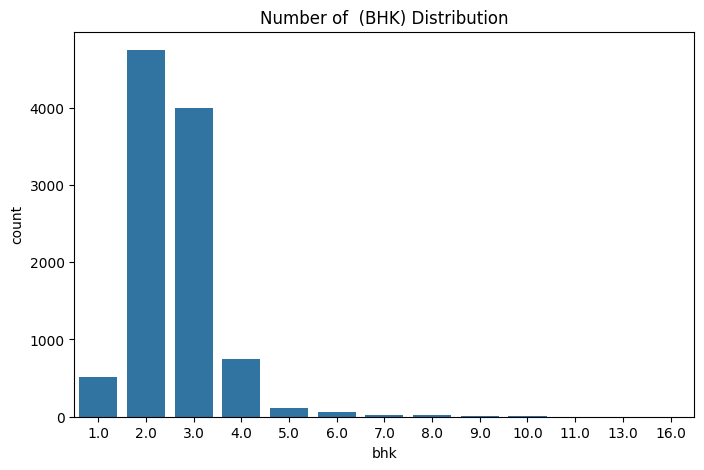

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='bhk')
plt.title("Number of  (BHK) Distribution")
plt.show()


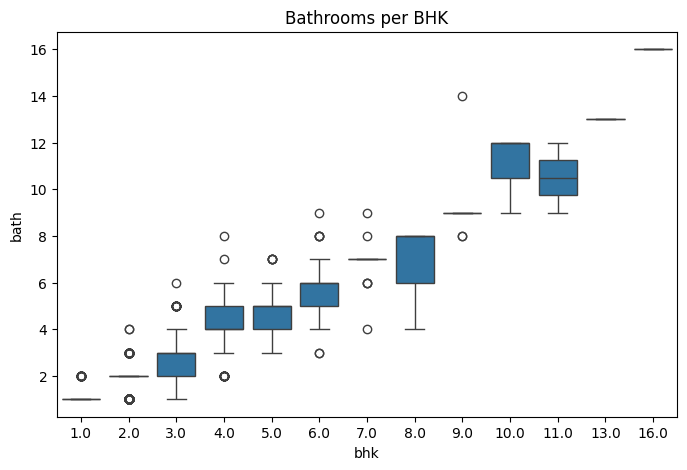

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='bhk', y='bath')
plt.title("Bathrooms per BHK")
plt.show()


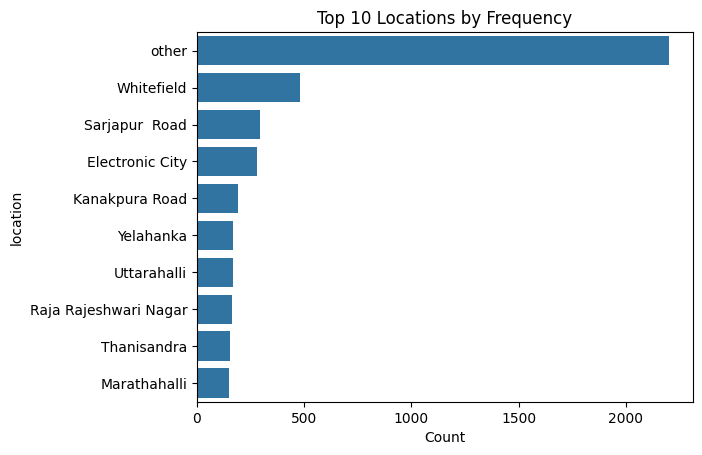

In [ ]:
top_locations = df['location'].value_counts().head(10)
sns.barplot(x=top_locations.values, y=top_locations.index)
plt.title("Top 10 Locations by Frequency")
plt.xlabel("Count")
plt.show()


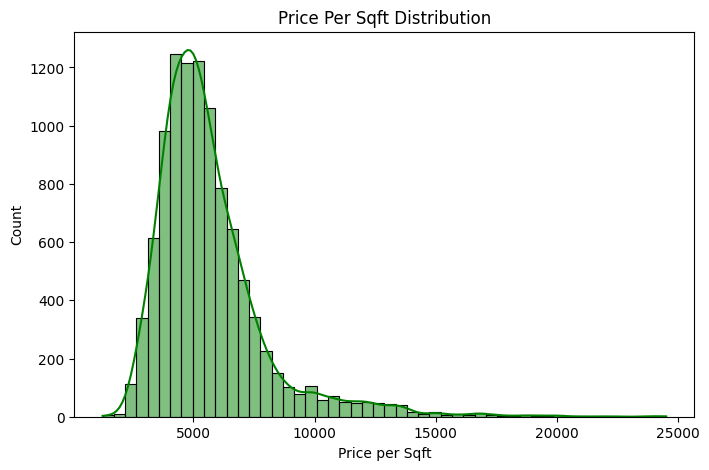

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['price_per_sqft'], bins=50, kde=True, color='green')
plt.title("Price Per Sqft Distribution")
plt.xlabel("Price per Sqft")
plt.show()


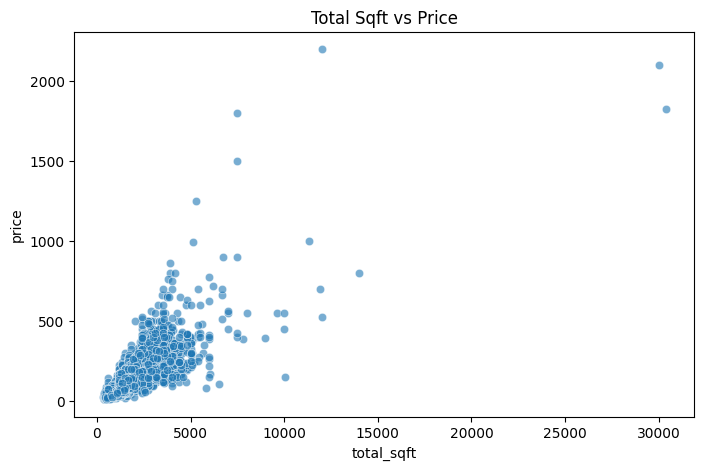

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='total_sqft', y='price', alpha=0.6)
plt.title("Total Sqft vs Price")
plt.show()


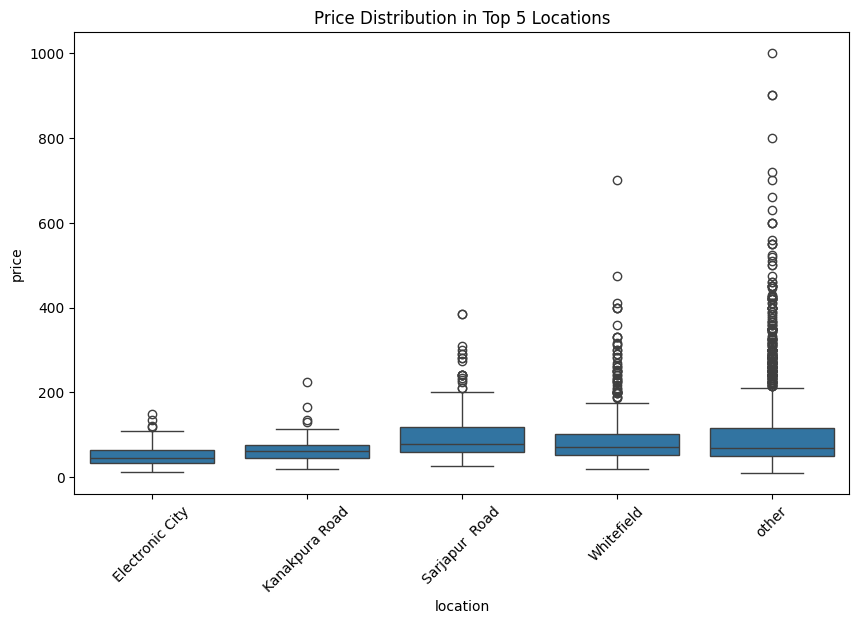

In [ ]:
top_locs = df['location'].value_counts().head(5).index
plt.figure(figsize=(10,6))
sns.boxplot(data=df[df['location'].isin(top_locs)], x='location', y='price')
plt.title("Price Distribution in Top 5 Locations")
plt.xticks(rotation=45)
plt.show()


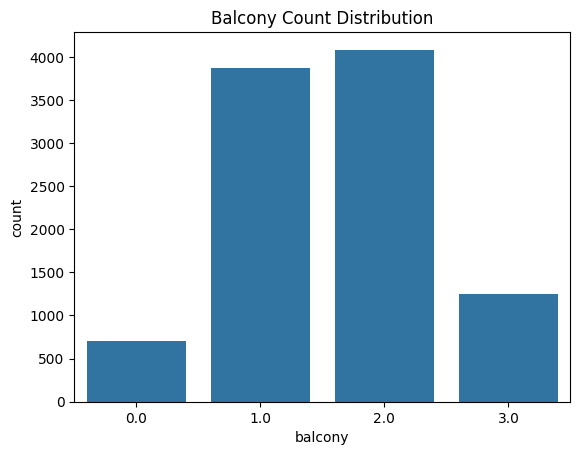

In [ ]:
sns.countplot(x='balcony', data=df)
plt.title("Balcony Count Distribution")
plt.show()


## FEATURE ENGINEERING

In [ ]:
# Select features and target
X = df[['total_sqft', 'bath', 'bhk', 'location']]
y = df['price']


In [ ]:
# One-hot encode 'location'
X = pd.get_dummies(X, drop_first=True)

In [ ]:
# Check shape and preview
print("X shape:", X.shape)
print("y shape:", y.shape)
X.head()

X shape: (10223, 257)
y shape: (10223,)


,total_sqft,bath,bhk,location_1st Block Koramangala,location_1st Phase JP Nagar,location_2nd Phase Judicial Layout,location_2nd Stage Nagarbhavi,location_5th Block Hbr Layout,location_5th Phase JP Nagar,location_6th Phase JP Nagar,...,location_Vishveshwarya Layout,location_Vishwapriya Layout,location_Vittasandra,location_Whitefield,location_Yelachenahalli,location_Yelahanka,location_Yelahanka New Town,location_Yelenahalli,location_Yeshwanthpur,location_other
0,2850.0,4.0,4.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,3.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1875.0,2.0,3.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1200.0,2.0,3.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1235.0,2.0,2.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## MODEL BUILDING

linear regression

In [ ]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lr_mae = mean_absolute_error(y_test, y_pred)

# Print results
print(f"Linear Regression R² Score: {r2:.4f}")
print(f"Linear Regression RMSE: ₹{rmse:.2f} Lakhs")
print(f"Linear Regression MAE: ₹{lr_mae:.2f} Lakhs")

Linear Regression R² Score: 0.7817
Linear Regression RMSE: ₹38.98 Lakhs
Linear Regression MAE: ₹19.56 Lakhs


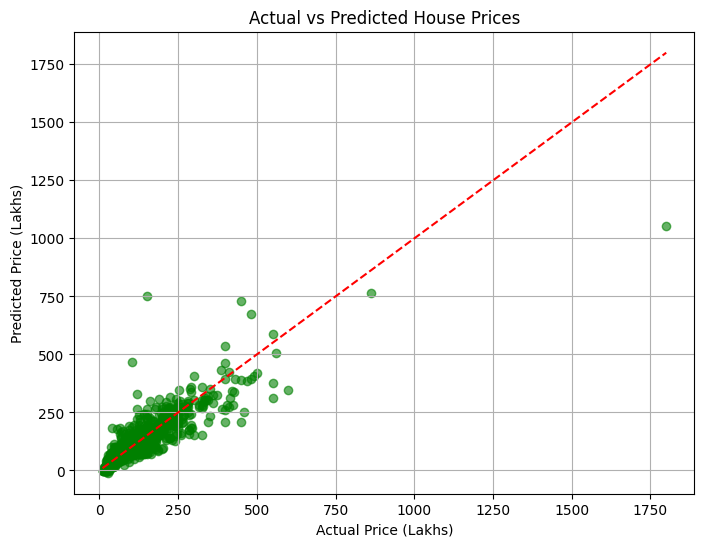

In [ ]:

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='green')
plt.xlabel("Actual Price (Lakhs)")
plt.ylabel("Predicted Price (Lakhs)")
plt.title("Actual vs Predicted House Prices")
plt.grid(True)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.show()


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train on training data
rf_model.fit(X_train, y_train)

# Predict on test data
rf_pred = rf_model.predict(X_test)

# Evaluate metrics
rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)

# Print results
print(f"Random Forest R² Score: {rf_r2:.4f}")
print(f"Random Forest RMSE: ₹{rf_rmse:.2f} Lakhs")
print(f"Random Forest MAE: ₹{rf_mae:.2f} Lakhs")


Random Forest R² Score: 0.7471
Random Forest RMSE: ₹41.96 Lakhs
Random Forest MAE: ₹17.62 Lakhs


Xgboost

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Initialize the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on test data
xgb_pred = xgb_model.predict(X_test)

# Evaluate performance
xgb_r2 = r2_score(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)

# Print results
print(f"XGBoost R² Score: {xgb_r2:.4f}")
print(f"XGBoost RMSE: ₹{xgb_rmse:.2f} Lakhs")
print(f"XGBoost MAE: ₹{xgb_mae:.2f} Lakhs")


XGBoost R² Score: 0.7810
XGBoost RMSE: ₹39.04 Lakhs
XGBoost MAE: ₹19.16 Lakhs


# Linear Regression has the best R² and RMSE, meaning it's best at explaining the variation in prices overall.

# Random Forest has the lowest MAE, meaning it makes the smallest average mistakes — possibly more stable.

# XGBoost is close to Linear Regression, performing well on all metrics but not the best on any one.

In [ ]:

# Metrics
models = ['Linear Regression', 'Random Forest', 'XGBoost']

r2_scores = [0.7817, 0.7471, 0.7810]
rmse_vals = [38.98, 41.96, 39.04]
mae_vals = [19.56, 17.62, 19.16]


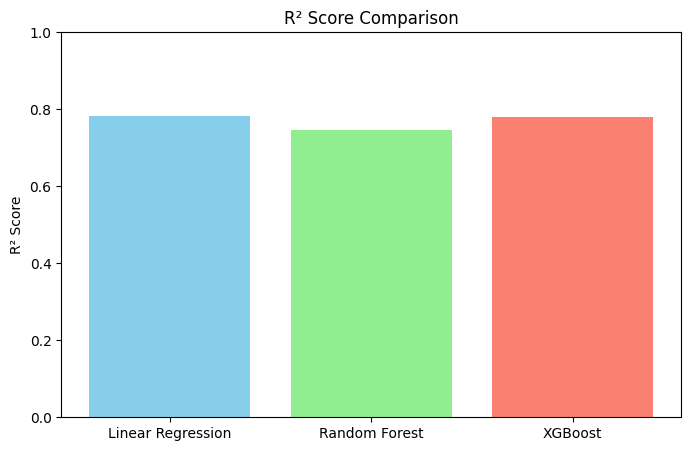

In [ ]:
# Plot R² Score
plt.figure(figsize=(8,5))
plt.bar(models, r2_scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.title("R² Score Comparison")
plt.ylabel("R² Score")
plt.ylim(0, 1)
plt.show()

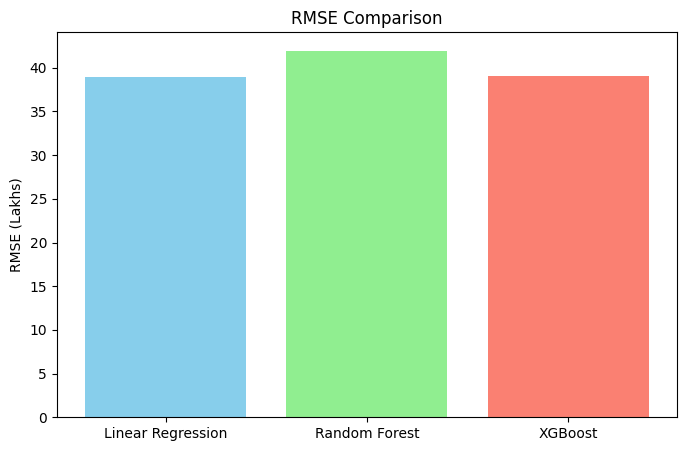

In [ ]:
# Plot RMSE
plt.figure(figsize=(8,5))
plt.bar(models, rmse_vals, color=['skyblue', 'lightgreen', 'salmon'])
plt.title("RMSE Comparison")
plt.ylabel("RMSE (Lakhs)")
plt.show()

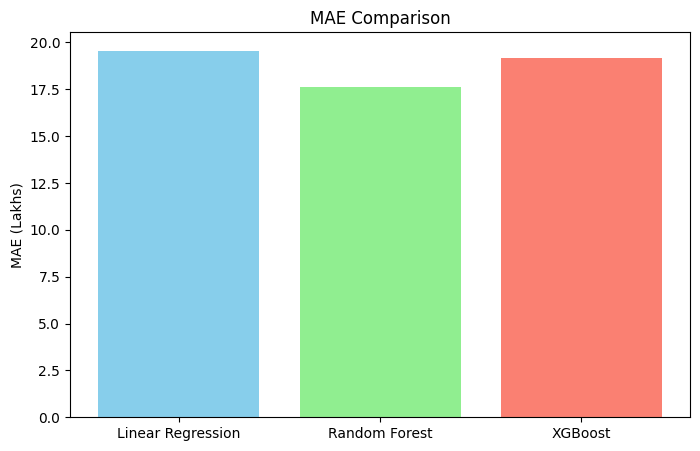

In [ ]:
# Plot MAE
plt.figure(figsize=(8,5))
plt.bar(models, mae_vals, color=['skyblue', 'lightgreen', 'salmon'])
plt.title("MAE Comparison")
plt.ylabel("MAE (Lakhs)")
plt.show()



🔎 Interpretation:

Our best model (XGBoost) explains ~78% of the variation in house prices.

On average, its predictions are ₹19.16 lakhs off, which is acceptable for real estate.

Random Forest had the smallest average error, so it makes fewer large mistakes.

In [ ]:
df_new = df.copy()


In [ ]:
df_new['price_per_sqft'] = df_new['price'] * 100000 / df_new['total_sqft']

In [ ]:
location_stats = df_new.groupby('location')['price_per_sqft'].mean().reset_index()


In [ ]:
from sklearn.cluster import KMeans

# Choose number of clusters (e.g., 5 zones)
kmeans = KMeans(n_clusters=5, random_state=42)

# Fit on average price per sqft
location_stats['location_cluster'] = kmeans.fit_predict(location_stats[['price_per_sqft']])


In [ ]:
df_new = df_new.merge(location_stats[['location', 'location_cluster']], on='location', how='left')


In [ ]:
X_new = df_new[['total_sqft', 'bath', 'bhk', 'location_cluster']]
y_new = df_new['price']


In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"RMSE: ₹{rmse:.2f} Lakhs")
print(f"MAE: ₹{mae:.2f} Lakhs")


R² Score: 0.7953
RMSE: ₹37.75 Lakhs
MAE: ₹17.96 Lakhs


            Feature  Importance
0        total_sqft    0.663511
3  location_cluster    0.249419
2               bhk    0.058845
1              bath    0.028225


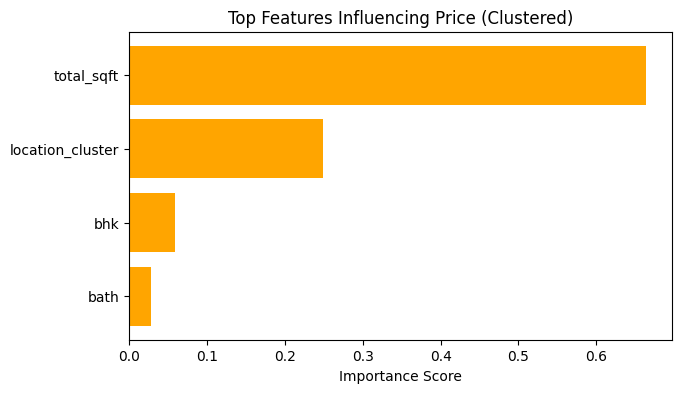

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

importances = xgb_model.feature_importances_
feature_names = X_new.columns

top_features = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_features = top_features.sort_values(by='Importance', ascending=False)

print(top_features)

# Plot
plt.figure(figsize=(7, 4))
plt.barh(top_features['Feature'], top_features['Importance'], color='orange')
plt.xlabel("Importance Score")
plt.title("Top Features Influencing Price (Clustered)")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
import gradio as gr
import pandas as pd

# Get one-hot location column names
location_columns = [col for col in X.columns if col.startswith("location_")]
location_list = sorted([col.replace("location_", "") for col in location_columns])

def predict_price(total_sqft, bath, bhk, location):
    # Initialize input with 0s for all columns
    input_dict = {col: 0 for col in X.columns}

    # Set actual values
    input_dict['total_sqft'] = total_sqft
    input_dict['bath'] = bath
    input_dict['bhk'] = bhk

    # Set location to 1
    loc_col = f'location_{location}'
    if loc_col in input_dict:
        input_dict[loc_col] = 1
    else:
        return " Invalid location selected."

    # Convert to DataFrame
    input_df = pd.DataFrame([input_dict], columns=X.columns)

    # Predict
    try:
        predicted_price = model.predict(input_df)[0]
        return f" Estimated Price: ₹{predicted_price:.2f} Lakhs"
    except Exception as e:
        return f" Prediction failed: {str(e)}"

# Gradio UI
demo = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Number(label="Total Sqft", value=1000),
        gr.Number(label="Bathrooms", value=2),
        gr.Number(label="BHK", value=2),
        gr.Dropdown(choices=location_list, label="Location")
    ],
    outputs="text",
    title="🏠 Bangalore House Price Predictor (Linear Regression)",
    description="Enter property details to estimate the price using Linear Regression."
)

demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0a8723935adaf40940.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
